In [1]:
# !sudo python3 -m pip install -U slackclient

In [2]:
# !sudo apt-get install python3-mysqldb

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
from pandas.io.json import json_normalize

import time


In [5]:
import json
from slackclient import SlackClient

# Read the access token from the file
secrets_file = 'slack_secret.json'
f = open(secrets_file, 'r') 
content = f.read()
f.close()
auth_info = json.loads(content)
token = auth_info["access_token"]
sc = SlackClient(token)


In [6]:
# Parameters to connect to MySQL database
parameters = {
    'host':     'localhost', 
    'username': 'root', 
    'password': 'dwdstudent2015', 
    'database': 'slack',
    'port':     '3306',
    'charset':  'utf8',
    'use_unicode': True
}

In [7]:
import mysql.connector
from sqlalchemy import create_engine


template = 'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}?charset={charset}'
conn_string = template.format(**parameters)

engine = create_engine(conn_string, echo=False)


In [24]:
df = pd.read_sql("SELECT * FROM messages", con=engine)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

In [9]:
baseurl = "http://ipython-panos.ipeirotis.com:5000/"

{'channel': 'C1WBCLJQ3',
 'ok': True,
 'ts': '1469808296.000164',
 'message': {'text': 'Channel Sentiment Report',
  'attachments': [{'fallback': '720x432px image',
    'text': 'Sentiment on channel #citimeetings',
    'image_width': 720,
    'image_height': 432,
    'image_url': 'http://ipython-panos.ipeirotis.com:5000/plots/citimeetings-1469808294.4646113.png',
    'image_bytes': 28500,
    'id': 1},
   {'fallback': '720x432px image',
    'text': 'Sentiment on channel #engineering',
    'image_width': 720,
    'image_height': 432,
    'image_url': 'http://ipython-panos.ipeirotis.com:5000/plots/engineering-1469808294.698574.png',
    'image_bytes': 53758,
    'id': 2},
   {'fallback': '720x432px image',
    'text': 'Sentiment on channel #general',
    'image_width': 720,
    'image_height': 432,
    'image_url': 'http://ipython-panos.ipeirotis.com:5000/plots/general-1469808295.1838245.png',
    'image_bytes': 50804,
    'id': 3},
   {'fallback': '720x432px image',
    'text': 'Sentime

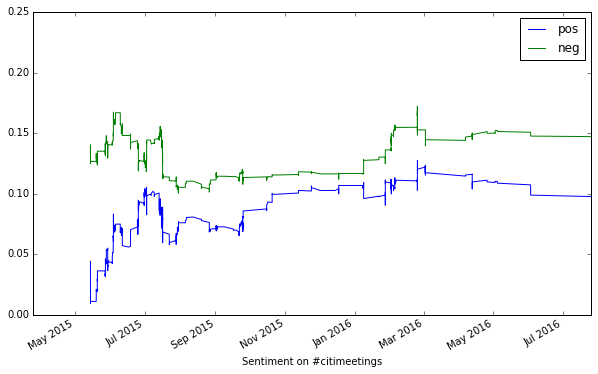

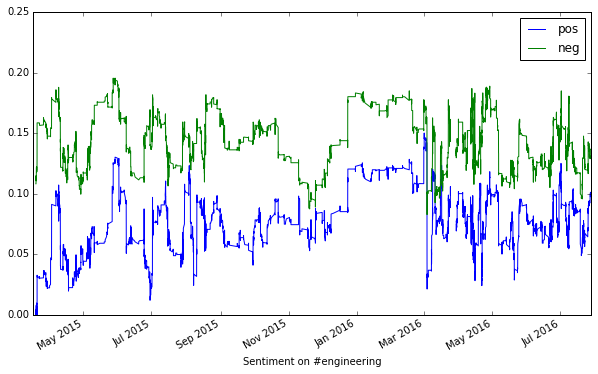

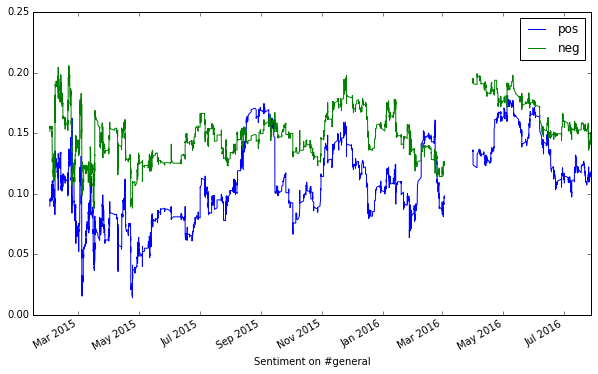

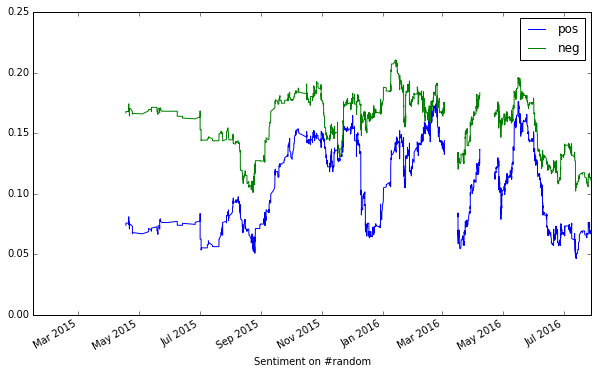

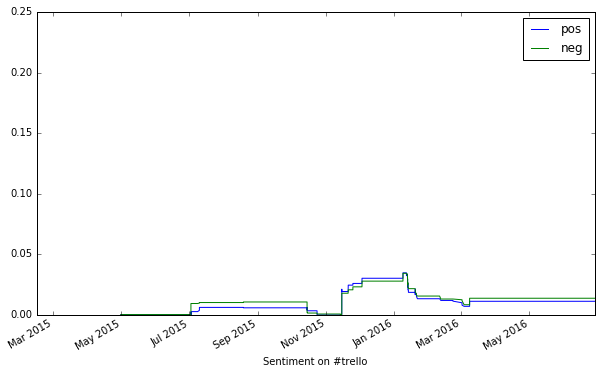

In [10]:
# Generate channel sentiment reports

df_channels = pd.read_sql("SELECT * FROM channels", con=engine)
df_channels.set_index('id', inplace=True)

attachments = []

for i, row in df_channels[["name"]].iterrows():
    ts = str(time.time())
    channel_id = i
    channel_name = row["name"]
    plot_df = df[ df['channel_id'] == channel_id].sort_index()
    if len(plot_df)>2000:
        ax = plot_df.rolling(window=300).mean()[['pos', 'neg']].plot(figsize=(10,6), ylim=(0,0.25))
        ax.set_xlabel("Sentiment on #"+channel_name)
        fig = ax.get_figure()
        filename = 'plots/'+channel_name+'-'+ts+'.png'
        fig.savefig(filename)
        attachment = {
            "image_url": baseurl + filename,
            "text": "Sentiment on channel #" + channel_name
        }
        attachments.append(attachment)
        
sc.api_call("chat.postMessage", channel="#bot_stats", text="Channel Sentiment Report", attachments=attachments)

In [11]:
#user_stats = df.groupby(df['user']).mean()

#data = df_users[['profile.real_name']].join(user_stats)
#data

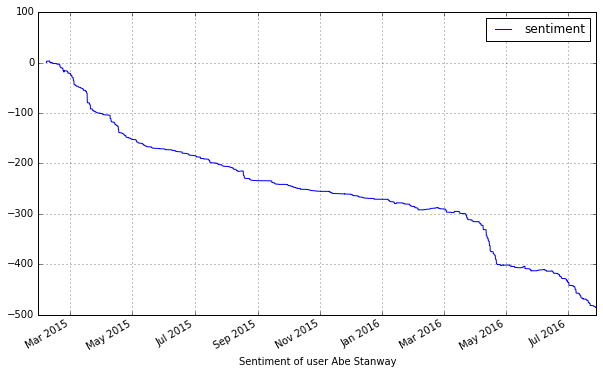

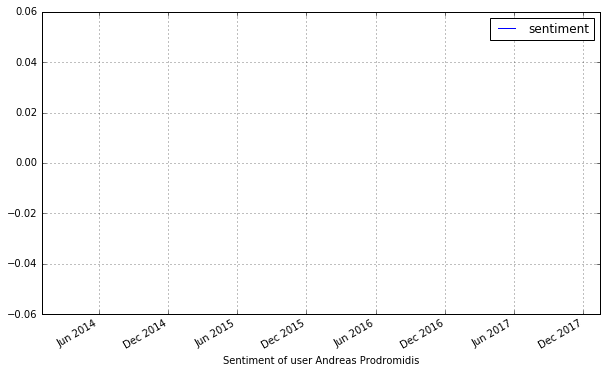

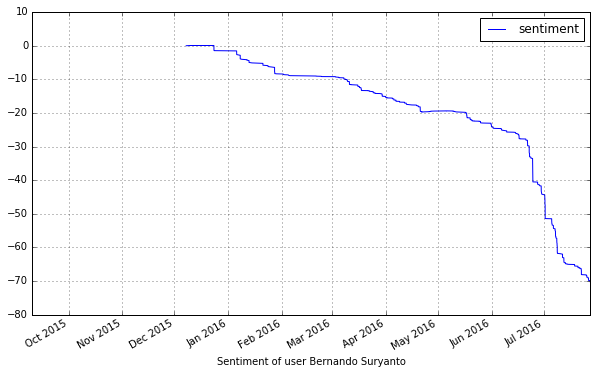

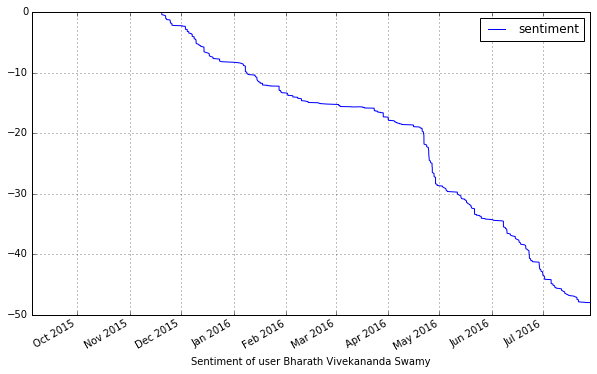

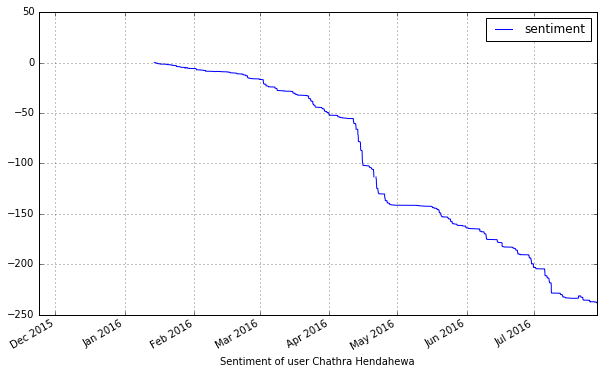

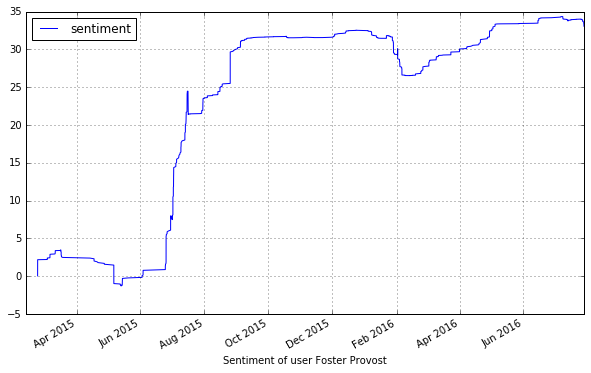

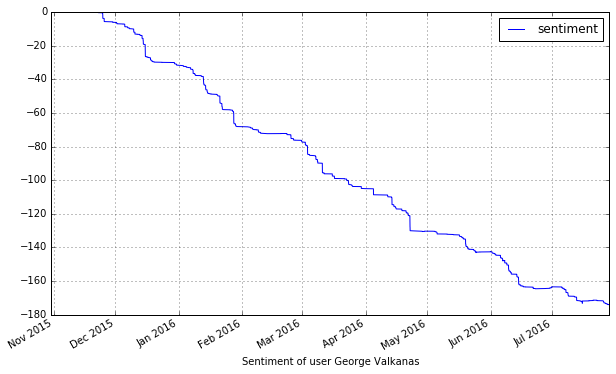

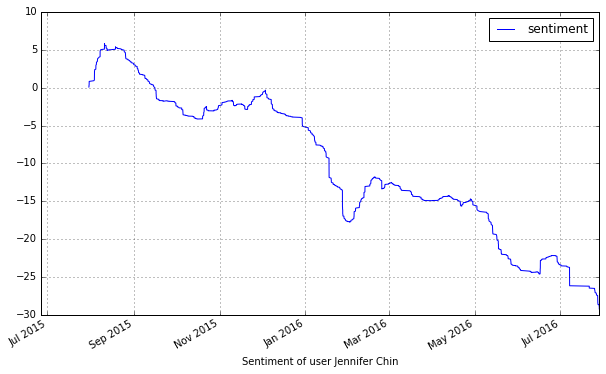

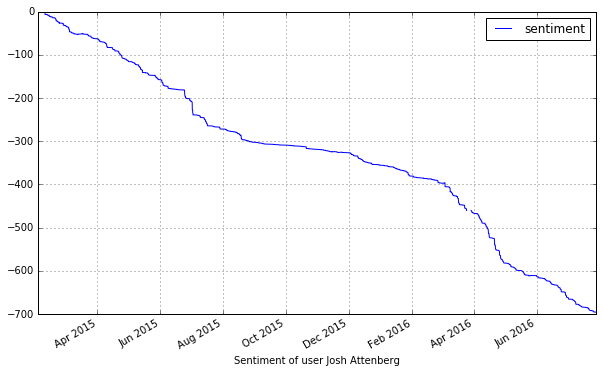

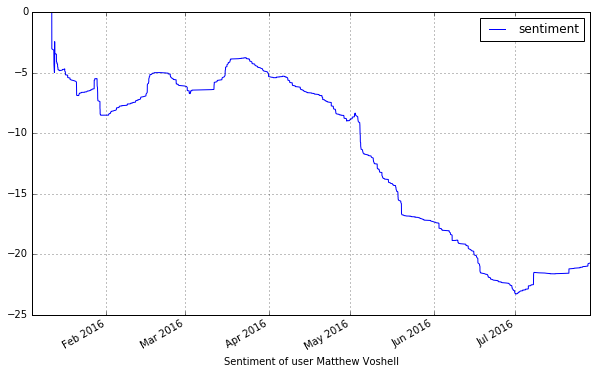

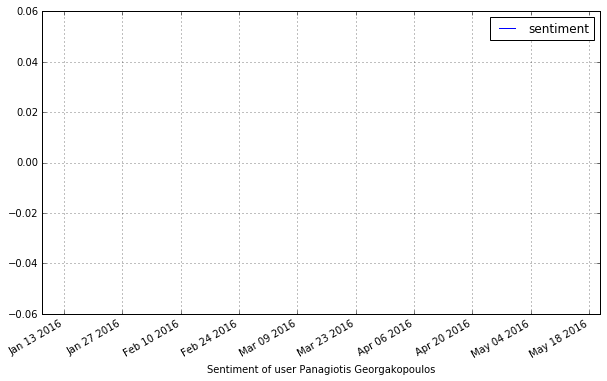

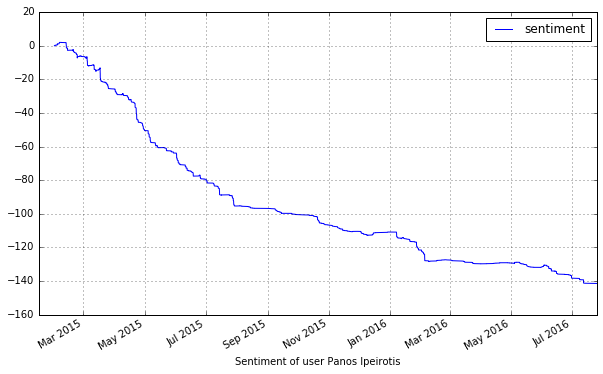

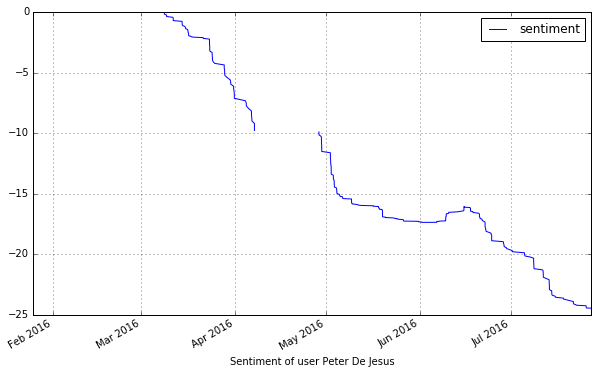

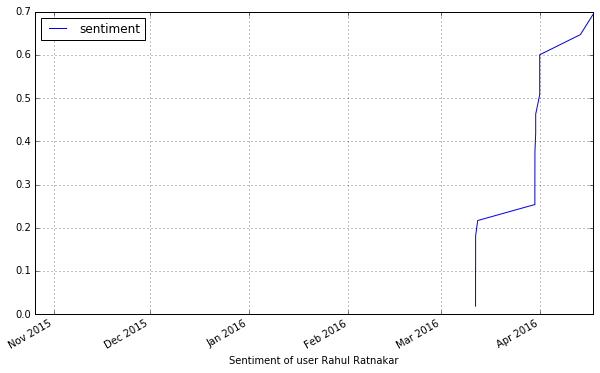

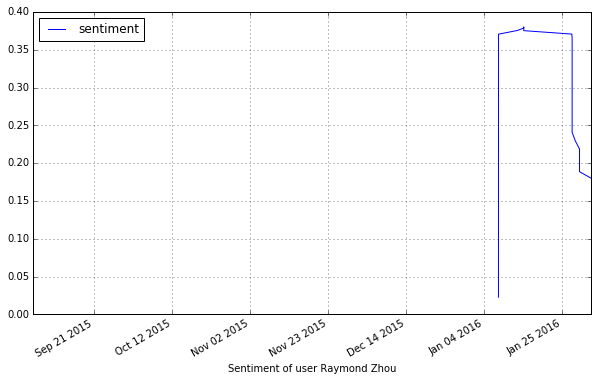

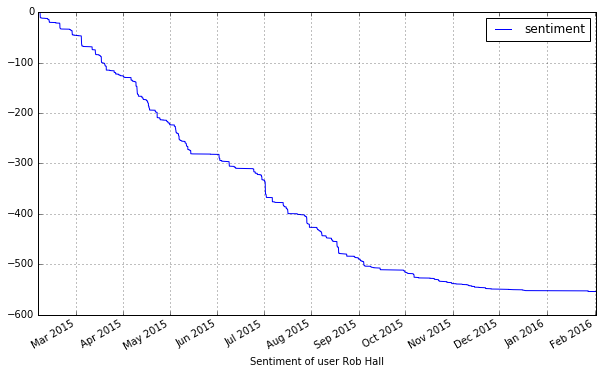

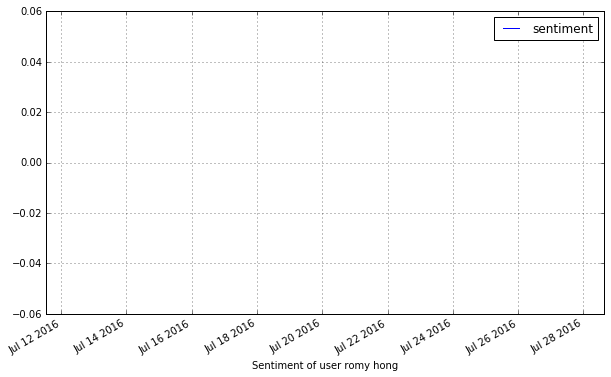

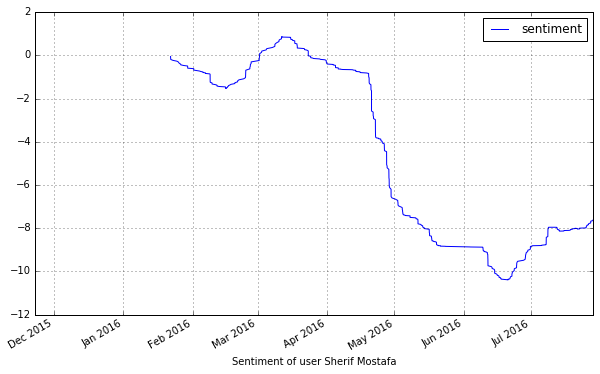

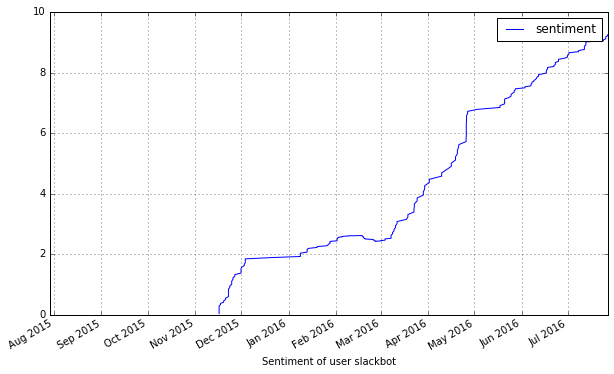

In [23]:
# Generate user sentiment reports

df_users = pd.read_sql("SELECT * FROM users WHERE deleted=False AND is_bot=False", con=engine)
df_users.set_index('id', inplace=True)

attachments = []

for i, row in df_users[['profile.real_name']].iterrows():
    ts = str(time.time())
    user_id = i
    user_name = row["profile.real_name"]
    plot_df = df[ (df['user'] == user_id)].sort_index()
    plot_df["diff"] = plot_df['pos'] - plot_df['neg']
    plot_df["sentiment"] = plot_df["diff"].rolling(center=False, win_type='parzen', window=100).mean()
    # plot_df = plot_df.rolling(window=200, win_type='parzen').mean()
    
    if len(plot_df) == 0:
        continue
    ax = plot_df[['sentiment']].cumsum().plot(figsize=(10,6))
    ax.set_xlabel("Sentiment of user "+user_name)
    ax.grid(True)
    fig = ax.get_figure()
    filename = 'plots/'+user_id+'-'+ts+'.png'
    fig.savefig(filename)
    attachment = {
        "image_url": baseurl + filename,
        "text": "Sentiment of user " + user_name
    }
    attachments.append(attachment)

# sc.api_call("chat.postMessage", channel="#bot_stats", text="User Sentiment Report", attachments=attachments)
    

In [28]:
df_users['profile.real_name']

id
U03G25UQP                  Abe Stanway
U0HV21Z1B          Andreas Prodromidis
U0ADAS0UX            Bernando Suryanto
U0A65SZ9D    Bharath Vivekananda Swamy
U0F4T2A14            Chathra Hendahewa
U03LA69EQ               Foster Provost
U0DHPSAP9              George Valkanas
U06SQ69K7                Jennifer Chin
U03HC5M66               Josh Attenberg
U0HLS92BX              Matthew Voshell
U0HV142N4    Panagiotis Georgakopoulos
U03C9Q002              Panos Ipeirotis
U0KABE4AY               Peter De Jesus
U0D5XPZHU               Rahul Ratnakar
U0A6CJ57Z                 Raymond Zhou
U03J6878G                     Rob Hall
U1QGZ9316                    romy hong
U0F2VCRBN               Sherif Mostafa
USLACKBOT                     slackbot
Name: profile.real_name, dtype: object

In [44]:
df_users.index.values

array(['U03G25UQP', 'U0HV21Z1B', 'U0ADAS0UX', 'U0A65SZ9D', 'U0F4T2A14',
       'U03LA69EQ', 'U0DHPSAP9', 'U06SQ69K7', 'U03HC5M66', 'U0HLS92BX',
       'U0HV142N4', 'U03C9Q002', 'U0KABE4AY', 'U0D5XPZHU', 'U0A6CJ57Z',
       'U03J6878G', 'U1QGZ9316', 'U0F2VCRBN', 'USLACKBOT'], dtype=object)

In [129]:
data = []

# for i, row in df_users[['profile.real_name']].iterrows()

user_id = 'U0HLS92BX'
user_name = 'Matthew Voshell'

print(user_name)
for j, row in df[['user','message']].iterrows():
    user = row['user']
    if user == user_id:
        tag = 'pos'
    else:
        tag = 'neg'
    data.append( (tag, row['message']) )

data

Matthew Voshell


[('neg', '<@U03C9Q002|panos> has joined the channel'),
 ('neg', '<@U03C9Q002|panos> has joined the channel'),
 ('neg', '<@U03C9Q002|panos> has joined the channel'),
 ('neg', '<@U03C9Q002|panos> has joined the channel'),
 ('neg', '<@U03C8NS83|jattenberg> has joined the channel'),
 ('neg', '<@U03C8NS83|jattenberg> has joined the channel'),
 ('neg', '<@U03C8NS83|jattenberg> has joined the channel'),
 ('neg', '<@U03C8NS83|jattenberg> has joined the channel'),
 ('neg', 'hi'),
 ('neg', 'do you use the web service or the app?'),
 ('neg', 'i wonder if theres a way to relay this to a normal IRC client'),
 ('neg', 'Never used it before'),
 ('neg', 'But it was recommended to me '),
 ('neg', '#detectica'),
 ('neg', 'is there a way to see who else is in the channel?'),
 ('neg', 'You and me :)'),
 ('neg',
  'I think that "presence" is ambiguous when you are connected with phone etc'),
 ('neg', 'but I do see a "green" light next to your name'),
 ('neg', 'and I see the names on the upper right corner'

In [130]:
# This is the number of positive sentences
len([tag for (tag, s) in data if tag=='pos'])

1901

In [131]:
# This is the number of negative sentences
len([tag for (tag, s) in data if tag=='neg'])

57075

In [132]:
import nltk

def features(msg):
    if msg==None or len(msg)==0 or pd.isnull(msg):
        return {}
    sent_tokens = nltk.word_tokenize(msg)
    # document_words = nltk.pos_tag(sent_tokens)
    features = {}
    #for word, tag in document_words:
    for word in sent_tokens:
        if word in df_users.index.values:
            continue
        if '|' in word:
            continue
        #if tag.startswith('NNP'):
        #features['%s/%s' % (word, tag)] = True
        features[word] = True
    return features

labeled_features = [(features(sent), tag) for (tag, sent) in data]

In [133]:
import random

test_set_size = int(len(labeled_features)/8)
random.shuffle(labeled_features)
train_set, test_set = labeled_features[test_set_size:], labeled_features[:test_set_size]


In [134]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [138]:
msg = classifier.show_most_informative_features(100)

Most Informative Features
                Material = True              pos : neg    =    252.5 : 1.0
                  pinned = True              pos : neg    =    199.3 : 1.0
                 `Today` = True              pos : neg    =    191.9 : 1.0
                     Yea = True              pos : neg    =    177.4 : 1.0
                   Image = True              pos : neg    =    171.7 : 1.0
                  Design = True              pos : neg    =    165.5 : 1.0
       utm_medium=social = True              pos : neg    =    151.5 : 1.0
           //medium.com/ = True              pos : neg    =    151.5 : 1.0
                     yea = True              pos : neg    =    133.7 : 1.0
              Foundation = True              pos : neg    =    131.3 : 1.0
                 YouTube = True              pos : neg    =    131.3 : 1.0
     utm_campaign=buffer = True              pos : neg    =    131.3 : 1.0
                  worthy = True              pos : neg    =    111.1 : 1.0

In [136]:
m = '''
                Material = True              pos : neg    =    252.5 : 1.0
                  pinned = True              pos : neg    =    199.3 : 1.0
                 `Today` = True              pos : neg    =    191.9 : 1.0
                     Yea = True              pos : neg    =    177.4 : 1.0
                   Image = True              pos : neg    =    171.7 : 1.0
                  Design = True              pos : neg    =    165.5 : 1.0
       utm_medium=social = True              pos : neg    =    151.5 : 1.0
           //medium.com/ = True              pos : neg    =    151.5 : 1.0
                     yea = True              pos : neg    =    133.7 : 1.0
              Foundation = True              pos : neg    =    131.3 : 1.0
                 YouTube = True              pos : neg    =    131.3 : 1.0
     utm_campaign=buffer = True              pos : neg    =    131.3 : 1.0
                  worthy = True              pos : neg    =    111.1 : 1.0
                invision = True              pos : neg    =    111.1 : 1.0
                   now.. = True              pos : neg    =    111.1 : 1.0
                     biz = True              pos : neg    =    111.1 : 1.0
                  sketch = True              pos : neg    =    103.0 : 1.0
                   whois = True              pos : neg    =     90.9 : 1.0
                    York = True              pos : neg    =     90.9 : 1.0
//i.giphy.com/Q56SF4czEtSZG.gif = True              pos : neg    =     90.9 : 1.0
                 sprints = True              pos : neg    =     90.9 : 1.0
  utm_source=twitter.com = True              pos : neg    =     90.9 : 1.0
                 Channel = True              pos : neg    =     90.9 : 1.0
                      ha = True              pos : neg    =     81.9 : 1.0
                  lookup = True              pos : neg    =     78.8 : 1.0
                  walked = True              pos : neg    =     70.7 : 1.0
                  time.. = True              pos : neg    =     70.7 : 1.0
              Experience = True              pos : neg    =     70.7 : 1.0
                personas = True              pos : neg    =     70.7 : 1.0
                   staff = True              pos : neg    =     70.7 : 1.0
'''

In [137]:
sc.api_call("chat.postMessage", channel="#bot_stats", text="@matthew characteristic phrases:\n```"+m+"```")

{'channel': 'C1WBCLJQ3',
 'ok': True,
 'ts': '1470106499.000002',
 'message': {'text': '@matthew characteristic phrases:\n```\n                Material = True              pos : neg    =    252.5 : 1.0\n                  pinned = True              pos : neg    =    199.3 : 1.0\n                 `Today` = True              pos : neg    =    191.9 : 1.0\n                     Yea = True              pos : neg    =    177.4 : 1.0\n                   Image = True              pos : neg    =    171.7 : 1.0\n                  Design = True              pos : neg    =    165.5 : 1.0\n       utm_medium=social = True              pos : neg    =    151.5 : 1.0\n           //medium.com/ = True              pos : neg    =    151.5 : 1.0\n                     yea = True              pos : neg    =    133.7 : 1.0\n              Foundation = True              pos : neg    =    131.3 : 1.0\n                 YouTube = True              pos : neg    =    131.3 : 1.0\n     utm_campaign=buffer = True      